# Problem Statement





ERC is a task that aims at predicting emotion of each utterance in a conversation. The following is an excerpt of a conversation with each utterance tagged with corresponding emotion and sentiment label.

![alt text](example.jpg "Title")


# Hierarchical Transformer Network for Utterance-Level Emotion Recognition
This is the Pytorch implementation Utterance-level Emotion Recognition [paper](https://arxiv.org/ftp/arxiv/papers/2002/2002.07551.pdf)

# Overview

Though predicting the emotion of a single utterance or sentence, i.e. emotion detection, is a well discussed subject in natural language understanding literature, EmoContext has several novel challenges. In this paper, we address four challenges in utterance-level emotion recognition in dialogue systems: 
- Emotion depend on the context of previous utterances in the dialogue 
- long-range contextual information is hard to be effectively captured; 
- Datasets are quite small. 
- the class distribution of training data is significantly different from that of the test data. Consequently, a model trained on the training data might not perform well on the test data.

- We propose a hierarchical transformer framework with a lower-level transformer to model the word-level inputs and an upper-level transformer to capture the contexts of utterance-level embeddings. 


# Dataset
Dataset includes the training data set consisting of 30160 dialogues, and two evaluation data sets, Test1 and Test2, containing
2755 and 5509 dialogues respectively. The Training dataset is a .txt file containing 5 columns :

 - ID - Contains a unique number to identify each training sample
 - Turn 1 - Contains the first turn in the three turn conversation, written by User 1
 - Turn 2 - Contains the second turn, which is a reply to the first turn in conversation and is written by User 2
 - Turn 3 - Contains the third turn, which is a reply to the second turn in the conversation, which is written by User 1
 - Label - Contains the human judged label of Emotion of Turn 3 based on the conversation for the given training sample. It is always one of the four values - 'happy', 'sad, 'angry' and 'others'
 
The Dev set and the Test set contains the first 4 columns as mentioned above. The 5th column - 'Label' is absent from those 2 sets. Training data consists of about 5k samples each from 'angry', 'sad', 'happy' class, and 15k samples from 'others' class, whereas, both Dev and Test sets have a real life distribution, which is about 4% each of 'angry', 'sad', 'happy' class and the rest is 'others' class. 
    
    

In [108]:
import torch
import os
import random
import pandas as pd
import functools
import time
import math
import argparse


from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler


from ipywidgets import interact
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer

from collections import defaultdict
from sklearn.metrics import f1_score
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [9]:
# Timer
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Read Dataset CSV Files

In [10]:
path = 'data/clean_train.txt'
df_train = pd.read_csv(path, delimiter='\t', index_col='id')
path = 'data/clean_val.txt'
df_val = pd.read_csv(path, delimiter='\t', index_col='id')
path = 'data/clean_test.txt'
df_test = pd.read_csv(path, delimiter='\t', index_col='id')
df_train.head()

,turn1,turn2,turn3,label
id,,,,
0,do not worry i am girl,hmm how do i know if you are,what ' s ur name ?,others
1,when did i ?,saw many times i think shame,no . i never saw you,angry
2,by,by google chrome,where you live,others
3,u r ridiculous,i might be ridiculous but i am telling the tru...,u little disgusting whore,angry
4,just for time pass,wt do u do 4 a living then,maybe,others


In [11]:
df_train.shape, df_val.shape, df_test.shape

((30160, 4), (2755, 4), (5509, 4))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30160 entries, 0 to 30159
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   turn1   30160 non-null  object
 1   turn2   30160 non-null  object
 2   turn3   30160 non-null  object
 3   label   30160 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [20]:
df_train['label'].value_counts()

others    14948
angry      5506
sad        5463
happy      4243
Name: label, dtype: int64

#  Comparison of class distribution in Training vs Evaluation data sets

| Emotion | Happy | Sad | Angry | others | # |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Train | 4243 | 5463 |5506 | 14948| 30160|
| Dev | 142 | 125 |150 | 2338| 2755|
| Test | 284 | 250 |298 | 4677| 5509|

In [22]:
data = [df_train['label'], df_val['label'], df_test['label']]
columns=list(('Training', 'Validation', 'Test'))
df_labels = pd.concat(data, axis=1, keys=columns)

<ipython-input-23-cc3f761f0e4e>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


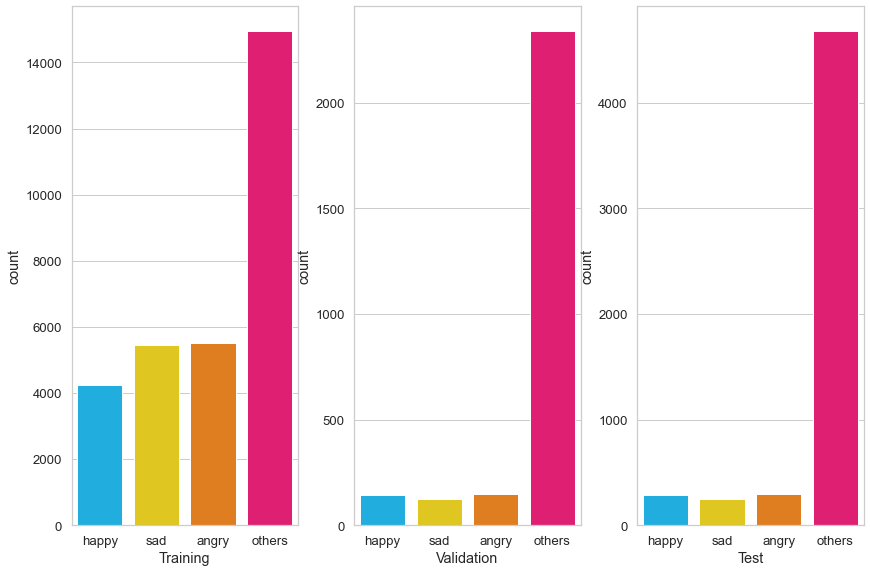

In [23]:
fig, ax =plt.subplots(1,3)

fig.tight_layout()
sns.countplot(x="Training",   data=df_labels, order = ['happy', 'sad', 'angry', 'others'] , ax=ax[0])
sns.countplot(x="Validation", data=df_labels, order = ['happy', 'sad', 'angry', 'others'], ax=ax[1])
sns.countplot(x="Test",       data=df_labels, order = ['happy', 'sad', 'angry', 'others'], ax=ax[2])
fig.show()

# Scale of class imbalance is different in Training and Evaluation data sets
| Emotion | Happy | Sad | Angry | others |
| :-: | :-: | :-: | :-: | :-: |
| Train | 14% | 18% |18% | 50%|
| Dev | 5% | 4.5% |5.5% | 85%|
| Test | 5% | 4.5% |5.5% | 85%|

In [27]:
train = pd.Series(['Training'] , ['name'])
train = train.append(df_labels['Training'].value_counts().div(df_labels['Training'].value_counts().sum()))
val = pd.Series(['Validation'] , ['name'])
val = val.append(df_labels['Validation'].value_counts().div(df_labels['Validation'].value_counts().sum()))
test = pd.Series(['Test'] , ['name'])
test = test.append(df_labels['Test'].value_counts().div(df_labels['Test'].value_counts().sum()))

df_stacked = pd.DataFrame(columns = list(('name', 'happy' , 'sad', 'angry', 'others')))

df_stacked = df_stacked.append(train,ignore_index=True)
df_stacked = df_stacked.append(val,ignore_index=True)
df_stacked = df_stacked.append(test,ignore_index=True)

<AxesSubplot:title={'center':'Stacked Bar Graph'}, xlabel='name'>

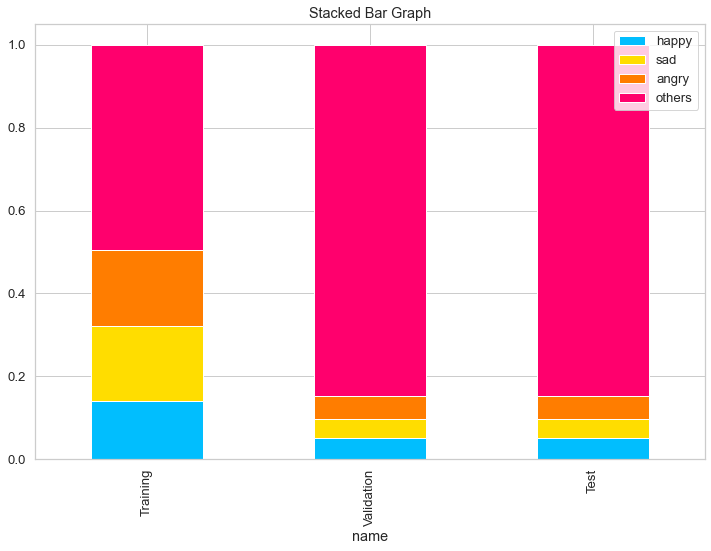

In [29]:
# plot a Stacked Bar Chart using matplotlib
df_stacked.plot(
    x = 'name',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = False, 
   )

# Distribution of Sequence Length in Train Set
Most of the utterances seem to contain less than 75 tokens, but we’ll be on the safe side and choose a maximum length of 100 while tokenizing



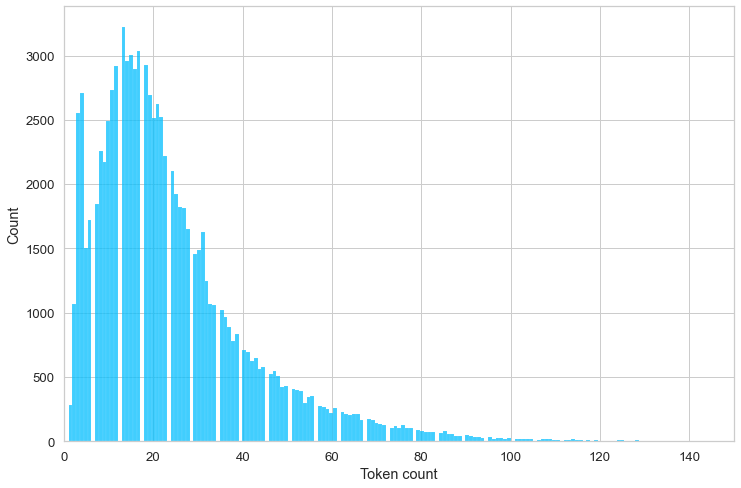

In [31]:
token_lens = []
for col in ['turn1', 'turn2', 'turn3']:
    for tokens in df_train[col]:
        token_lens.append(len(tokens))
        
sns.histplot(token_lens)
plt.xlim([0, 150]);
plt.xlabel('Token count Distribution');

# Distribution of Word Count per emotion class
It can be observed that happiness is often expressed in fewer words as compared to other emotions

<AxesSubplot:ylabel='Count'>

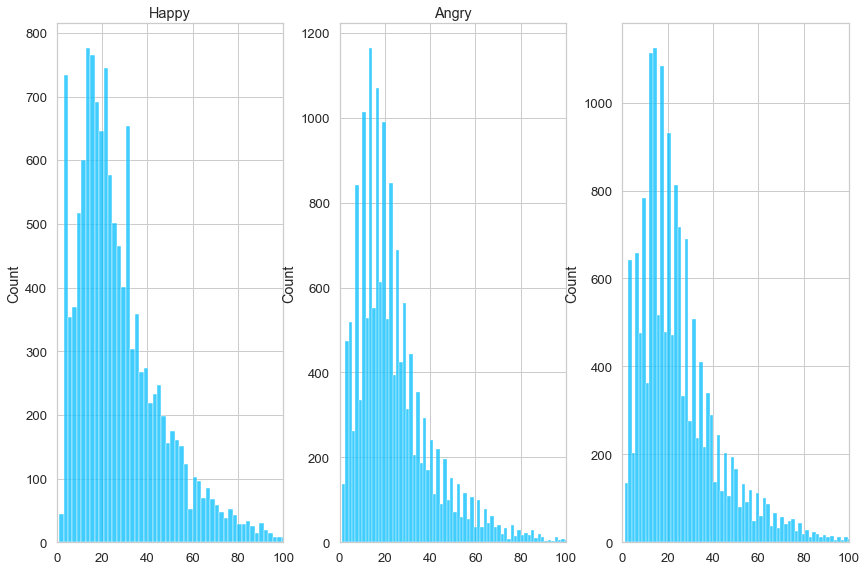

In [91]:
d = {"happy":[],"sad":[],"angry":[] };
for col in ['turn1', 'turn2', 'turn3']:
    for label, token in zip(df_train.label, df_train[col]):
        if (label == "others"):
            continue
        d[label].append(len(token))
        
fig, ax =plt.subplots(ncols=3)
fig.tight_layout()
ax[0].set_title('Happy')
ax[0].set_xlim([0, 100])
sns.histplot(d['happy'] , ax=ax[0])

ax[1].set_title('Sad')
ax[1].set_xlim([0, 100])
sns.histplot(d['sad'] , ax=ax[1])

ax[1].set_title('Angry')
ax[2].set_xlim([0, 100])
sns.histplot(d['angry'] , ax=ax[2])

# Comparision of word count distribution per emotion class


In [93]:
df = df_train
d = {"happy":[],"sad":[],"angry":[] };
for i, a,b,c in zip(df.label, df.turn1,df.turn2,df.turn3):
    if (i == "others"):
        continue
    d[i].append([len(a), len(b), len(c)]) 


In [94]:
index = [1, 2, 3,
         4, 5, 6, 7, 8, 9]
columns = ["happy", "sad","angry"]
df_wc =  pd.DataFrame(columns = columns, index=index)
df_wc = df_wc.fillna(0)
for keys in d.keys():
    for row in d[keys]:
        for i in range(1, 10):
            if i == 9:
                for j in row:
                    if j>=40:
                        df_wc.loc[i, keys] +=1
            else:
                for j in row:
                    if j in list(range((i-1)*5, i*5)):
                       
                        df_wc.loc[i, keys] +=1
                
df_wc.index = ['0-4', '5-9', '10-14', '15-19','20-24', '25-29', '30-34', '35-39' , '>=40']          

<AxesSubplot:title={'center':'Distribution of Utterance Word Count per emotion class'}>

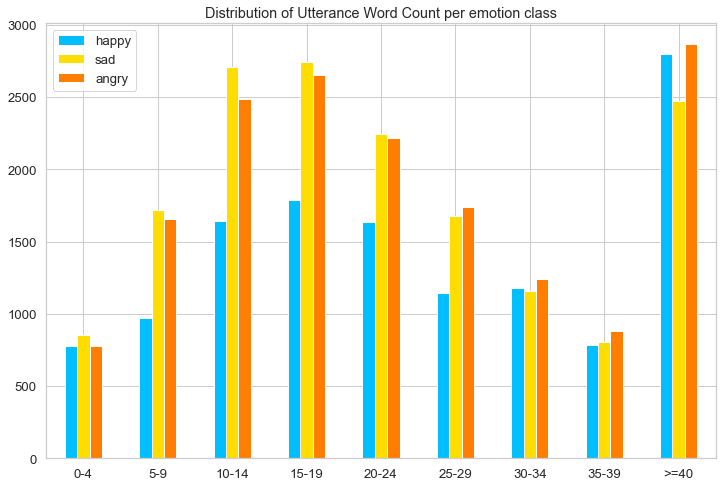

In [95]:
df_wc.plot.bar(rot=0, title = 'Distribution of Utterance Word Count per emotion class')

# Data Preprocessing

Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are using BERT for modelling the word level inputs, we need to do following preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We will use the pretrained bert model and tokenizers from the Transformers Library 

In [96]:

def transform_data(df, max_seq_len):
    """
    returns the padded input ids and attention masks according to the DistilBert tokenizer
    """
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    def tokenize_fct(turn):
        return tokenizer.encode(turn, truncation = True, add_special_tokens=True, max_length=max_seq_len)
    
    tokenized = df[['turn1','turn2','turn3']].applymap(tokenize_fct)
    padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
    attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
    return padded, attention_mask, tokenized

In [97]:
def get_labels(df, emo_dict):
    """
    returns the labels according to the emotion dictionary
    """
    return torch.tensor([emo_dict[label] for label in df['label'].values])

In [98]:
emo_dict = {'others': 0, 'sad': 1, 'angry': 2, 'happy': 3}
labels = torch.tensor([emo_dict[label] for label in df['label'].values])

In [99]:

def dataloader(path, max_seq_len, batch_size, emo_dict, labels = True, eval = False):
    """
    Transforms the .csv data stored in `path` according to DistilBert features and returns it as a DataLoader 
    """
    df = pd.read_csv(path, delimiter='\t', index_col='id')
    #df = df.iloc[0:1000, :]
    print(df.shape)
    padded, attention_mask, tokenizer = transform_data(df, max_seq_len)
    
    if labels:
        dataset = TensorDataset(padded, attention_mask, get_labels(df, emo_dict))
    
    else:
        dataset = TensorDataset(padded, attention_mask)
      
    train_sampler = None

    return DataLoader(dataset, batch_size=batch_size, shuffle= not(eval) , 
                      sampler=train_sampler, num_workers=0),  df.shape[0]


## Transformer Sentence Embeddings

Lower Transformer is used to create sentence embeddings for each utterance. We use a pretrained DistilBert model to obtain contextual word embeddings and then concatenate the CLS token embedding and the mean of the last layer. Note that in order to feed batches into out model we need to temporarily flatten our `input_ids`, i.e. we get three times as many input sentences as the specified `batch_size`.

For more information on the (Distil)Bert models one can look at 
Jay Alammar's blog posts ([A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) and [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)) where also the following illustration is taken from.

![DistilBert output](./images/bert-distilbert-output-tensor-predictions.png)

Further references:
 
* [DistilBert paper](https://arxiv.org/abs/1910.01108) and [blog post](https://medium.com/huggingface/distilbert-8cf3380435b5)
* [Original Bert (Bidirectional Encoder Representations from Transformers) paper](https://arxiv.org/abs/1810.04805)
* [tutorial for custom PyTorch modules](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
* [Huggingface transformers documentation](https://huggingface.co/transformers/v2.3.0/index.html)

The DistilBert model outputs 

* 768-dimensional embeddings for each of the 'max_seq_len' tokens and each of the three utterances of the `batch_size` conversations and
* a list of the hidden-states in all of the 6 DistilBert transformer layers (including the first embedding)
* We concatenate the CLS token embedding and the mean of the last layer to build encoding of individual utterance

In [100]:

class sentence_embeds_model(torch.nn.Module):
    """
    instantiates the pretrained DistilBert model and the linear layer
    """
    
    def __init__(self, dropout = 0.1):
        super(sentence_embeds_model, self).__init__()
        
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=dropout, 
                                                           output_hidden_states=True)
        self.embedding_size = 2 * self.transformer.config.hidden_size
        
    def layerwise_lr(self, lr, decay):
        """
        returns grouped model parameters with layer-wise decaying learning rate
        """
        bert = self.transformer
        num_layers = bert.config.n_layers
        opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
        opt_parameters += [{'params': bert.transformer.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
        return opt_parameters
    
    
               
    def forward(self, input_ids = None, attention_mask = None, input_embeds = None):
        """
        returns the sentence embeddings
        """
        if input_ids is not None:
            input_ids = input_ids.flatten(end_dim = 1)
        if attention_mask is not None:
            attention_mask = attention_mask.flatten(end_dim = 1)
        output = self.transformer(input_ids = input_ids, 
                                  attention_mask = attention_mask, inputs_embeds = input_embeds)
    
        cls = output[0][:,0]
        hidden_mean = torch.mean(output[1][-1],1)
        sentence_embeds = torch.cat([cls, hidden_mean], dim = -1)
        
        return sentence_embeds.view(-1, 3, self.embedding_size)

## Context Transformer and Classification

Next we use another transformer model to create contextual sentence embeddings, i.e. we model that a conversation consists of three utterances. Then, we add a classification model for the emotion of the last utterance where we augment the loss by a binary loss due to the unbalanced data.

We use 

* a linear projection of the sentence embeddings to a given `projection_size`
* a (not pre-trained) DistilBertForSequenceClassification and flip the order of the utterances as the first input embedding gets classified by default
* only one attention head

In [ ]:
# export 
class context_classifier_model(torch.nn.Module):
    """
    instantiates the DisitlBertForSequenceClassification model, the position embeddings of the utterances, 
    and the binary loss function
    """
    
    def __init__(self, embedding_size, projection_size, n_layers, emo_dict, dropout = 0.1):
        super(context_classifier_model, self).__init__()
        
        self.projection_size = projection_size
        self.projection = torch.nn.Linear(embedding_size, projection_size)         
        self.position_embeds = torch.nn.Embedding(3, projection_size)
        self.norm = torch.nn.LayerNorm(projection_size)
        self.drop = torch.nn.Dropout(dropout)
    
        context_config = DistilBertConfig(dropout=dropout, 
                                dim=projection_size,
                                hidden_dim=4*projection_size,
                                n_layers=n_layers,
                                n_heads = 1,
                                num_labels=4)

        self.context_transformer = DistilBertForSequenceClassification(context_config)
        self.others_label = emo_dict['others']
        self.bin_loss_fct = torch.nn.BCEWithLogitsLoss()
        
    def bin_loss(self, logits, labels):
        """
        defined the additional binary loss for the `others` label
        """
        bin_labels = torch.where(labels == self.others_label, torch.ones_like(labels), 
                                 torch.zeros_like(labels)).float()
        bin_logits = logits[:, self.others_label]    
        return self.bin_loss_fct(bin_logits, bin_labels)

    def forward(self, sentence_embeds, labels = None):
        """
        returns the logits and the corresponding loss if `labels` are given
        """
        
        position_ids = torch.arange(3, dtype=torch.long, device=sentence_embeds.device)
        position_ids = position_ids.expand(sentence_embeds.shape[:2]) 
        position_embeds = self.position_embeds(position_ids)
        sentence_embeds = self.projection(sentence_embeds) + position_embeds 
        sentence_embeds = self.drop(self.norm(sentence_embeds))
        if labels is None:
            return self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)[0]
        
        else:
            output =  self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)
            loss = output[0]
            logits = output[1]
            return loss + self.bin_loss(logits, labels), logits

# Metrices

We define the metrics, i.e. microaveraged precision, recall, and f1-score (ignoring the others class), for the evaluation of our model according to the [SemEval-2019 Task 3 challenge](https://www.aclweb.org/anthology/S19-2005/). 

In [104]:
# export
def metrics(loss, logits, labels):
    cm = torch.zeros((4,4), device = loss.device)
    preds = torch.argmax(logits, dim=1)
    acc = (labels == preds).float().mean()
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
        
    tp = cm.diagonal()[1:].sum()
    fp = cm[:, 1:].sum() - tp
    fn = cm[1:, :].sum() - tp 
    return {'val_loss': loss, 'val_acc': acc, 'tp': tp, 'fp': fp, 'fn': fn}

def f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    prec_rec_f1['precision'] = tp / (tp + fp)
    prec_rec_f1['recall'] = tp / (tp + fn)
    prec_rec_f1['f1_score'] = 2 * (prec_rec_f1['precision'] * prec_rec_f1['recall']) / (prec_rec_f1['precision'] + prec_rec_f1['recall'])
    return prec_rec_f1

## Define the pytorch lightning module
Implement the pytorch framework to concatenate the above 2 models. Pytorch lightning module has following main hooks
* training_step 

In [105]:
# export
class EmotionModel(pl.LightningModule):
    """
    PyTorch Lightning module for the Contextual Emotion Detection in Text Challenge
    """

    def __init__(self):
        """
        pass in parsed HyperOptArgumentParser to the model
        """
        super(EmotionModel, self).__init__()

        self.model = 'Semeval'
        self.emo_dict = {'others': 0, 'sad': 1, 'angry': 2, 'happy': 3}
        self.max_seq_len = 10
        self.dropout = 0.1
        self.projection_size = 100
        self.n_layers = 1
        self.sentence_embeds_model = sentence_embeds_model(dropout = self.dropout)
        self.context_classifier_model = context_classifier_model(self.sentence_embeds_model.embedding_size,
                                                                 self.projection_size, 
                                                                 self.n_layers, 
                                                                 self.emo_dict, 
                                                                 dropout = self.dropout)
        

    def forward(self, input_ids, attention_mask, labels = None):
        """
        no special modification required for lightning, define as you normally would
        """
        sentence_embeds = self.sentence_embeds_model(input_ids = input_ids, 
                                                             attention_mask = attention_mask)
        return self.context_classifier_model(sentence_embeds = sentence_embeds, labels = labels)
    
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        """       
        input_ids, attention_mask, labels = batch
        loss, _ = self.forward(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
       
        tensorboard_logs = {'train_loss': loss}
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        """
        Lightning calls this inside the validation loop
        """
        input_ids, attention_mask, labels = batch

        loss, logits = self.forward(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        scores_dict = metrics(loss, logits, labels)

        return scores_dict

    def validation_end(self, outputs):
        """
        called at the end of validation to aggregate outputs
        :param outputs: list of individual outputs of each validation step
        :return:
        """
        
        tqdm_dict = {}

        for metric_name in outputs[0].keys():
            metric_total = 0

            for output in outputs:
                metric_value = output[metric_name]
                metric_total += metric_value
            if metric_name in ['tp', 'fp', 'fn']:
                tqdm_dict[metric_name] = metric_total
            else:
                tqdm_dict[metric_name] = metric_total / len(outputs)

               
        prec_rec_f1 = f1_score(tqdm_dict['tp'], tqdm_dict['fp'], tqdm_dict['fn'])
        tqdm_dict.update(prec_rec_f1) 
        self.log('valid_loss', tqdm_dict["val_loss"], prog_bar=False)
        self.log('valid_acc', tqdm_dict["val_acc"], prog_bar=False)
        print('\nError Metric {}'.format(tqdm_dict))
        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': tqdm_dict["val_loss"]}
        
        return result
    
    def test_step(self, batch, batch_idx):
 
        return self.validation_step(batch, batch_idx)

    
    def test_end(self, outputs):
        return self.validation_end(outputs)
    
    def configure_optimizers(self):
        """
        returns the optimizer and scheduler
        """
        params = model.sentence_embeds_model.layerwise_lr(args.lr, args.layerwise_decay)
        params += [{'params': model.context_classifier_model.parameters()}]
        self.optimizer = torch.optim.Adam(params, lr=args.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        return [self.optimizer], [self.scheduler]
    

   
    def train_dataloader(self):
         train_loader, _ = dataloader(args.train_file, args.max_seq_len, args.batch_size, self.emo_dict)
         return train_loader

    

    def val_dataloader(self):
        val_loader, _ =dataloader(args.val_file,  args.max_seq_len, args.batch_size, self.emo_dict)
        return val_loader

    def test_dataloader(self):
        test_loader, _ =  dataloader(args.test_file, args.max_seq_len, args.batch_size, self.emo_dict)
        return test_loader


In [106]:
# export
def get_args():
    """
        returns the Parser args
    """
    root_dir = os.getcwd()  
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--projection_size', type=int, default=100)
    parser.add_argument('--n_layers', type=int, default=2)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-5)
    parser.add_argument('--bert_lr', type=float, default=1e-5)
    parser.add_argument('--layerwise_decay', default=0.95, type=float,  
                    help='layerwise decay factor for the learning rate of the pretrained DistilBert')
    parser.add_argument('--train_file', default=os.path.join(root_dir, 'data/clean_train.txt'), type=str)
    parser.add_argument('--val_file', default=os.path.join(root_dir, 'data/clean_val.txt'), type=str)
    parser.add_argument('--test_file', default=os.path.join(root_dir, 'data/clean_test.txt'), type=str)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    parser.add_argument('--max_grad_norm', type=float, default=1.0)
    parser.add_argument('--epochs', type=int, default=3,
                        help='number of total epochs to run')
    parser.add_argument('--max_seq_len', type=int, default=10)
   
    parser.add_argument('--alpha', type=float, default=0.95)
    parser.add_argument('--seed', type=int, default=123,
                       help='seed for initializing training')
    parser.add_argument('--device', type=int, default=0)

    parser.add_argument('--evaluate', action='store_true')
    args = parser.parse_args(args=[])
    return args

In [109]:
args = get_args()
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
seed_everything(42, workers=True)

Global seed set to 42


42

In [110]:
model = EmotionModel()


In [111]:
    
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5, 
                                        verbose=True, mode='min')
    
    
trainer = pl.Trainer(default_root_dir=os.getcwd(),
                    gpus=(1 if torch.cuda.is_available() else 0),
                    max_epochs= 10,
                    fast_dev_run=False,
                    deterministic=True,
                    )
trainer.fit(model)
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 3.4 M 
----------------------------------------------------------------------
69.8 M    Trainable params
0         Non-trainable params
69.8 M    Total params
279.010   Total estimated model params size (MB)


(2755, 4)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


(30160, 4)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [113]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(5509, 4)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]